In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import scipy.sparse.linalg
import scipy 


In [172]:
class RadialDiffusivityEquationSolver:
    """
    A finite difference solver for the radial diffusivity equation.
    We use the coordinate transformation y = ln(r/rw) to set up and
    solve the pressure equation.

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Except for the number of grid blocks / points to use, all class
    instance attributes are provided with reasonable default values.

    Input arguments:

        name                                symbol      unit
        --------------------------------------------------------------
        Number of grid points                N          dimensionless
        well radius                          rw         ft
        extent of reservoir                  re         ft
        height of reservoir                  h          ft
        permeability                         k          mD
        porosity                             phi        dimensionless
        fluid viscosity                      mu         mPas (cP)
        total compressibility                ct         1 / psi
        constant flow rate at well           Q          bbl / day
        initial reservoir pressure           pi         psi
        constant time step                   dt         days
        maximal simulation time          max_time       days
        -------------------------------------------------------------
    """

    def __init__(self, N, rw=0.328, re = 100000., h=8.0,
                 k=500, phi=0.1, mu=1.0, ct=17.7e-6,
                 Q=1000, pi=2000, dt=0.1, max_time=10):

        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24*60*60
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325
        self.phi_ = phi
        self.mu_ = mu*1e-3
        self.ct_ = ct / self.psi_to_pa_
        self.eta_ = self.k_/(self.mu_*self.phi_*self.ct_)

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi*self.psi_to_pa_

        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_
        self.max_time_ = max_time*self.day_to_sec_
        self.current_time_ = max_time*self.day_to_sec_
        self.t_sec = int(round(self.current_time_))          #np.arange (used below) does not like non-integer steps. 
        self.time_steps_ = np.arange(1,self.t_sec, self.dt_) #Analytical solution not defined for t =0
            
        # Part4, Discrete midpoints
        self.yw_ = 0
        self.ye_ = np.log(self.re_/self.rw_)
        self.dy_ = (self.ye_-self.yw_)/self.N_
        self.y0_ = self.yw_ + 0.5*self.dy_
        self.y_mids = np.linspace(self.y0_,self.ye_ - 0.5*self.dy_, self.N_)
        self.r_from_mids = self.rw_*np.exp(self.y_mids)
        
        #Diffusivity beta
        self.beta_ = (self.Q_*self.mu_*self.dy_)/(2*np.pi*self.k_*self.h_)
        
        #Well pressure "global?"
        self.p0_ =[]
        self.pw_=[] # Not used??
        
        
    
    def line_source_solution(self, t, r):
        return self.pi_ + ((self.Q_*self.mu_)/(4*np.pi*self.k_*self.h_))*sc.expi(-(r**2)/(4*self.eta_*t)) 
    
    
    def line_source_solution_time_mod(self, t, r):
        return self.pi_ + ((self.Q_*self.mu_)/(4*np.pi*self.k_*self.h_))*sc.expi(-(r**2)/(4*self.eta_*t)) 
    
    def xi(self,y_i):
        """Function that calculates xi coefficient of y_i input"""
        return self.eta_*np.exp(-2*y_i)*self.dt_/((self.rw_*self.dy_)**2)   
     
    def setup_matrix(self):
        """Function that "sets up" a matrix by storing the coefficients of the linear difference equations
        over the time steps and grid points."""
        
        matrix = np.zeros((self.N_,self.N_))
        
        #First and last row
        matrix[0][0] = 1 + self.xi(self.y_mids[0])
        matrix[0][1] = - self.xi(self.y_mids[0])
        matrix[self.N_-1][self.N_-1] = 1 + self.xi(self.y_mids[self.N_-1])
        matrix[self.N_-1][self.N_-2] = -self.xi(self.y_mids[self.N_-1])
        
        #Mid-rows
        for index in range(self.N_):
            if index == 0 or index == (self.N_ -1):
                pass
            else:
                matrix[index][index-1] = -self.xi(self.y_mids[index])
                matrix[index][index] = 1 + 2*self.xi(self.y_mids[index])
                matrix[index][index+1] = -self.xi(self.y_mids[index])
        
        return(matrix)
   
    
    def setup_sparse_matrix(self):
        """ function that stores diagonal entries and sets up a sparce matrix"""
        
        main_diag =[1 + 2*self.xi(y) for y in self.y_mids]    #list comprehension assigns 1 +2*eta, to all diag-entries
        main_diag[0] = 1 + self.xi(self.y_mids[0])            #correcting first and last row
        main_diag[self.N_-1] = 1+ self.xi(self.y_mids[self.N_-1])
        over_diag = [-self.xi(y) for y in self.y_mids if y != self.y_mids[self.N_-1]]
        under_diag =[-self.xi(y) for y in self.y_mids if y != self.y_mids[0]]
       
        diagonals = [main_diag, over_diag, under_diag]
        sparse_matrix = scipy.sparse.diags(diagonals, [0, 1,-1], format ='csc')
        
        return sparse_matrix
        
    def rhs(self, p_vec):
        """Function that returns the right hand side of the vector equation"""
        p_vec[0] = p_vec[0] - self.xi(self.y_mids[0])*self.beta_
        return p_vec
        
               
    def top_level(self, sparse = 'True'):
        """top level function for executing simulation"""
        
        p_vec=self.N_*[self.pi_]        #initial pressure vector
        self.p0_ =[] 
        
        if sparse == 'True':
            matrix = self.setup_sparse_matrix()
            for i in (self.time_steps_):          #n from range (0,t) with stepsize dt: apply sparse solve n times. 
                p_vec = self.rhs(p_vec)
                p_vec = scipy.sparse.linalg.spsolve(matrix,p_vec)
                self.p0_.append(p_vec[0])
                
        else:
            matrix = self.setup_matrix()
            inverted_matrix = np.linalg.inv(matrix)
            for i in (self.time_steps_):  #n from range (0,t) with stepsize dt: apply invere matrix-mult n times. 
                self.p0_.append(p_vec[0])
                p_vec = self.rhs(p_vec)
                p_vec = np.matmul(inverted_matrix,p_vec)
           
        return(p_vec)
    
    def well_pressure_function(self,sparse='True'):
        self.top_level(self.max_time_)    #run top level to set p0_at_t to the values of p0 at time t.
        p_w = [p -0.5*self.beta_ for p in self.p0_ ]
        return p_w
    
    def plot_line_source_solution(self, t, r):    
        res_pres= self.line_source_solution(t, r)
        figure = plt.figure()
        plot = figure.add_subplot()
        plot.plot(r,res_pres)
        plot.set_title('Plot of analytical solution')
        plot.set_xscale('log')
        plt.xlabel('Radial distance from line source')
        plt.ylabel('Pressure [Pa]')
    
    def plot_both_radial(self,sparse ='True'):
        num_out = self.top_level(sparse)
        res_pres= self.line_source_solution(self.current_time_, self.r_from_mids)
        figure31 = plt.figure()
        plot31 = figure31.add_subplot()
        plot31.plot(self.r_from_mids, num_out , label = 'Numerical solution')
        plot31.plot(self.r_from_mids, res_pres, label ='Analytic solution')
        plot31.legend()
        plot31.set_xscale('log')
        plot31.set_title('Numerical solution')
        plt.xlabel('Radial distance from line source')
        plt.ylabel('Pressure [Pa], Calculated Numerically')


        
    def plot_all_of_them(self, file_x, file_y):
        numeric_out = self.well_pressure_function()
        num_out_psi = np.array(numeric_out)*self.psi_to_pa_**(-1)
        analytic_out = self.line_source_solution(self.time_steps_, self.rw_)
        analytic_out_psi = np.array(analytic_out)*self.psi_to_pa_**(-1)
        
        num_out_psi = num_out_psi[1:]
        analytic_out_psi = analytic_out_psi[1:]
        time_without_first = self.time_steps_[1:]
        
        grand_figure = plt.figure()
        sub = grand_figure.add_subplot()
        sub.scatter(time_without_first, num_out_psi, label ='Numerical solution PSI??')
        sub.scatter(time_without_first, analytic_out_psi, label ='Analytical solution PSI???')
        sub.scatter(file_x*self.day_to_sec_, file_y, label = 'Plot of data PSII???')
        sub.grid('True')
        sub.legend()
        sub.set_xscale('log')
        sub.set_title('One plot to rule them all')
        plt.xlabel('Time')
        plt.ylabel('Pressure [Psi???], Calculated Numerically in every conceivable way')

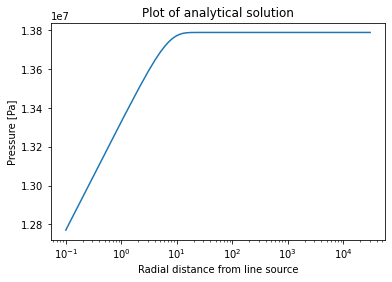

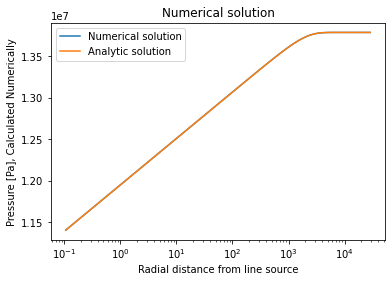

In [173]:
testing = RadialDiffusivityEquationSolver(100)

testing.plot_line_source_solution(10, np.arange(testing.rw_, testing.re_))

testing.plot_both_radial()



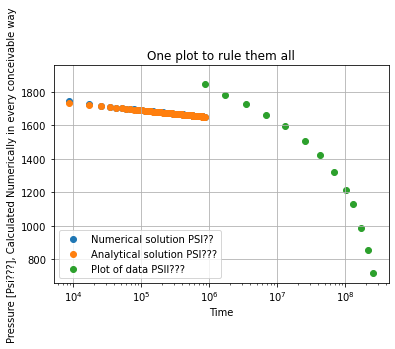

In [152]:

df2 = pd.read_csv('data/well_test.dat', skiprows=3, sep = '\t')
testing.plot_all_of_them(df2['time'],df2['well_pressure'])

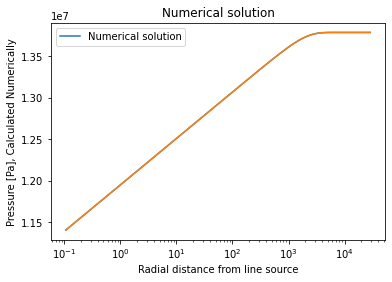

In [153]:
testing.plot_both_radial()

In [ ]:
    def plot_analytical_temporal(self):
        val = self.line_source_solution(self.time_steps_, self.rw_)
        
        figure43 = plt.figure()
        plot43 = figure43.add_subplot()
        plot43.plot(self.time_steps_, val , label = 'Analytic solution')
        plot43.set_xscale('log')
        plot43.set_title('Analytic solution')
        plt.xlabel('Time')
        plt.ylabel('Pressure [Pa], Calculated Numerically')
        
        
    def plot_numerical_temporal(self, sparse ='True'):
        num_out = self.well_pressure_function()
        
        figure43 = plt.figure()
        plot43 = figure43.add_subplot()
        plot43.plot(self.time_steps_, num_out , label = 'Numerical solution')
        plot43.set_xscale('log')
        plot43.set_title('Numerical solution')
        plt.xlabel('Time')
        plt.ylabel('Pressure [Pa], Calculated Numerically')